# Intrinsic periodicity of the SIR system
Continuing our investigation of the Susceptible-Infected-Recovered system, 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

With non-trivial endemic equilbrium 

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

General analysis of a system's stability of and approach to equilibria is beyond the scope of this notebook, and detailed discussions are available elsewhere (e.g., Keeling/Rohani Box 2.4).  In brief, one constructs the Jacobian of the system at the equilibrium points and computes its eigenvalues.  If all eigenvalues have negative real component, then the equilibrium is stable; if the dominant eigenvalues are complex conjugates, then system approaches equilibrium via damped oscillations, with damping constant equal to the real component and frequency equal to the imaginary component. This is the case for the SIR system around the non-trivial ($R_0 \gt 1$) equilibrium, with dominant eigenvalues:

$$
\Lambda = -\frac{\mu R_0}{2} \pm \frac{\sqrt{\mu^2 R_0^2 - \frac{4}{A G}}}{2} \\
\text{where} \:\: A = \frac{1}{\mu (R_0 -1)} and G = \frac{1}{\mu + \gamma}

$$

In general, $\mu^2 R_0^2$ is quite small, and the intrinsic periodicity of the system is $T \approx 2 \pi \sqrt{A G}$.

### Contruct the model
The model is contructed as in notebook 05.  As again, we are looking at behavior around the endemic equilibrium, the same considerations of large-ish populations and long simulations apply here. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will sample a set of $(\mu, \gamma, R_0)$ tuplets and confirm that the periodicity is   

### Future work
The addition of an exposed compartment with rate constant $\sigma$ should change this result, by changing the generation time $G$ to $\frac{1}{\mu + \gamma} + \frac{1}{\mu + \sigma}$


In [4]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import laser.core
import laser.generic
from laser.generic import Births_ConstantPop
from laser.generic import Infection
from laser.generic import Model
from laser.generic import Susceptibility
from laser.generic import Transmission
from laser.generic.importation import Infect_Random_Agents
from laser.generic.utils import seed_infections_randomly
from laser.generic.utils import set_initial_susceptibility_randomly

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")

np.__version__='2.3.4'
laser.core.__version__='0.7.0'
laser.generic.__version__='0.0.0'


OK, in testing here, we run into a couple of challenges, and my training in spectral
analysis is a bit old at this point.  Mainly, we're interested in relatively low-frequency
signals relative to our vector length - periods that can be order a few years in a sequence of a few decades,
so only a few oscillations.  Not impossible but tough
Second is that there are lots of other signals that will probably settle down over
time, but may not.  Lastly, there seem to be some windowing effects from the length of the
vector itself.
So some approaches to get arounds this:
Try to start relatively close to equilibrium
Use time-domain autocorrelation spectrum 
Instead of looking for the period of maximum power, specifically look for a peak in the vicinity of 
the expected period.


In [2]:
scenario = pd.DataFrame(data=[["homenode", 2e6]], columns=["name", "population"])
parameters = PropertySet(
    {"seed": 4, "nticks": 36500, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 45, "importation_period": 180, "importation_count": 3}
)

2025-03-10 11:24:31.520942: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 11:24:31.544663: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:43<00:00, 352.91it/s]


Completed the generic model at 2025-03-10 11:26:15.013562…
Susceptibility_census:     6,319,294 µs
Infection_census     :    38,935,262 µs
Transmission_census  :    18,202,216 µs
Model                :       203,810 µs
Infect_Random_Agents :       143,760 µs
Births_ConstantPop   :    11,180,252 µs
Susceptibility       :        49,312 µs
Infection            :    15,634,214 µs
Transmission         :   114,155,356 µs
Total:                   204,823,476 microseconds


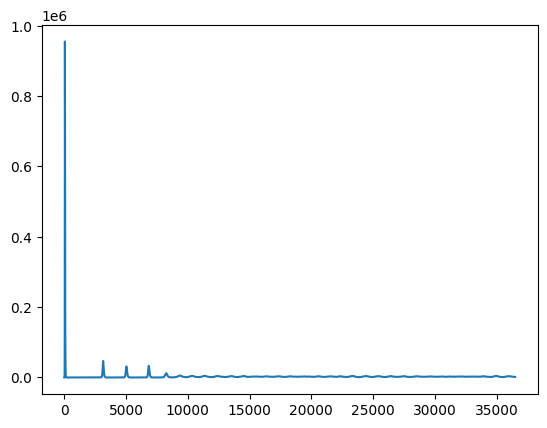

In [3]:
model = Model(scenario, parameters)
model.components = [
    Infect_Random_Agents,
    Births_ConstantPop,
    Susceptibility,
    Infection,
    Transmission,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

In [4]:
model.patches.cases[10000:10010]

array([[1180],
       [1172],
       [1182],
       [1203],
       [1197],
       [1221],
       [1234],
       [1234],
       [1246],
       [1270]], dtype=uint32)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times

In [4]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
births = np.squeeze(model.patches.births)
pops = np.squeeze(model.patches.populations)[:-1]

print("S+I+R = N:  " + str(np.isclose(cases + susc + rec, pops).all()))

S+I+R = N:  True


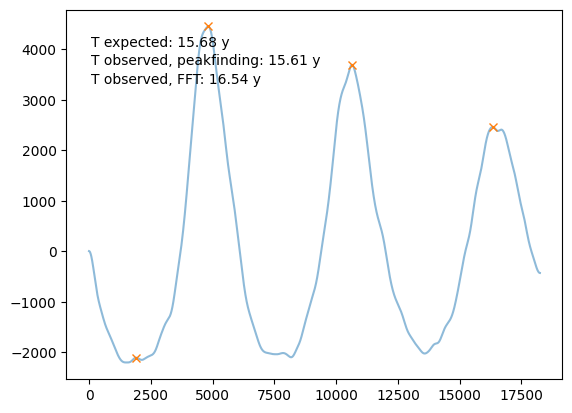

In [ ]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / ((R0 - 1) * mu) / 365
G = 1 / (mu + 1 / model.params.inf_mean) / 365
T_exp = 2 * np.pi * np.sqrt(A * G)


def ID_freq_peakfinder(y0, T_exp, cutoff=18250, plot=False):
    y = y0[cutoff:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance=T_exp * 365 / 2)
    if plot:
        plt.figure()
        plt.plot(y, alpha=0.5)
        plt.plot(peaks, y[peaks], "x")
    return np.median(np.diff(peaks)) / 365


T_obs_pf = ID_freq_peakfinder(np.squeeze(model.patches.cases), T_exp, plot=True)


def ID_freq_autocorr(y0, cutoff=18250):
    # Compute the FFT
    Y1 = np.fft.fft(y0[cutoff:] - np.mean(y0[cutoff:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    return peaks[0] / 365


T_obs_fft = ID_freq_autocorr(np.squeeze(model.patches.cases))

plt.text(0.05, 0.9, f"T expected: {T_exp:.2f} y", transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f"T observed, peakfinding: {T_obs_pf:.2f} y", transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f"T observed, FFT: {T_obs_fft:.2f} y", transform=plt.gca().transAxes)
plt.show()

### Larger test suite
OK, so now we are going to replicate the above test for many values of R0 and cbr, as a scientific validity test.

TODO: As written, this takes a long time.  That's because the space of random values being sampled occasionally produces models with long equilibration times and long periodicities.  So as of right now, these run for 100 years to sidestep this.  Should instead restrict the range of values - higher cbrs and R0s - so that the average age at infection is consistently lower and we can get away with running for like 30-50 years instead.  

2025-03-10 13:55:21.800742: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 13:55:21.842017: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:45<00:00, 344.77it/s]


Completed the generic model at 2025-03-10 13:57:07.711286…
Susceptibility_census:     6,943,136 µs
Transmission_census  :    19,280,492 µs
Infection_census     :    43,475,592 µs
Model                :       247,750 µs
Births_ConstantPop   :    16,195,488 µs
Susceptibility       :        55,472 µs
Transmission         :   102,614,084 µs
Infection            :    20,236,544 µs
Infect_Random_Agents :       193,048 µs
Total:                   209,241,606 microseconds
2025-03-10 13:57:07.793199: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 13:57:07.829296: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:45<00:00, 220.42it/s]

Completed the generic model at 2025-03-10 13:59:53.424167…
Susceptibility_census:     7,436,178 µs
Transmission_census  :    20,613,852 µs
Infection_census     :    46,784,314 µs
Model                :       270,690 µs
Births_ConstantPop   :    27,356,294 µs
Susceptibility       :        58,772 µs
Transmission         :   199,028,878 µs
Infection            :    26,501,892 µs
Infect_Random_Agents :       208,634 µs
Total:                   328,259,504 microseconds
2025-03-10 13:59:53.503457: Creating the generic model…
Initializing the generic model with 1 patches…


2025-03-10 13:59:53.534563: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:15<00:00, 269.61it/s]


Completed the generic model at 2025-03-10 14:02:08.915276…
Susceptibility_census:     7,335,330 µs
Transmission_census  :    20,231,246 µs
Infection_census     :    42,167,634 µs
Model                :       232,504 µs
Births_ConstantPop   :    26,504,526 µs
Susceptibility       :        55,610 µs
Transmission         :   146,895,770 µs
Infection            :    24,619,234 µs
Infect_Random_Agents :       199,510 µs
Total:                   268,241,364 microseconds
2025-03-10 14:02:08.995035: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 14:02:09.026644: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:49<00:00, 333.39it/s]


Completed the generic model at 2025-03-10 14:03:58.510616…
Susceptibility_census:     6,856,740 µs
Transmission_census  :    19,044,534 µs
Infection_census     :    42,980,444 µs
Model                :       233,146 µs
Births_ConstantPop   :    16,167,414 µs
Susceptibility       :        55,114 µs
Transmission         :   112,692,106 µs
Infection            :    18,587,070 µs
Infect_Random_Agents :       184,248 µs
Total:                   216,800,816 microseconds
2025-03-10 14:03:58.628217: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 14:03:58.682308: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:37<00:00, 231.90it/s]


Completed the generic model at 2025-03-10 14:06:36.076293…
Susceptibility_census:     7,431,120 µs
Transmission_census  :    21,307,864 µs
Infection_census     :    45,832,196 µs
Model                :       238,544 µs
Births_ConstantPop   :    29,309,318 µs
Susceptibility       :        57,152 µs
Transmission         :   180,725,952 µs
Infection            :    26,616,108 µs
Infect_Random_Agents :       211,176 µs
Total:                   311,729,430 microseconds
2025-03-10 14:06:36.155542: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 14:06:36.188907: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:01<00:00, 299.91it/s]

Completed the generic model at 2025-03-10 14:08:37.893270…
Susceptibility_census:     7,340,988 µs
Transmission_census  :    19,773,648 µs
Infection_census     :    44,949,744 µs
Model                :       226,972 µs
Births_ConstantPop   :    24,892,016 µs
Susceptibility       :        56,494 µs
Transmission         :   119,889,766 µs
Infection            :    23,658,280 µs
Infect_Random_Agents :       212,756 µs
Total:                   241,000,664 microseconds
2025-03-10 14:08:37.972117: Creating the generic model…
Initializing the generic model with 1 patches…


2025-03-10 14:08:38.002538: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:11<00:00, 277.95it/s]


Completed the generic model at 2025-03-10 14:10:49.321050…
Susceptibility_census:     7,375,044 µs
Transmission_census  :    20,306,450 µs
Infection_census     :    43,903,966 µs
Model                :       241,744 µs
Births_ConstantPop   :    27,957,710 µs
Susceptibility       :        57,000 µs
Transmission         :   131,658,808 µs
Infection            :    28,352,510 µs
Infect_Random_Agents :       211,702 µs
Total:                   260,064,934 microseconds
2025-03-10 14:10:49.399547: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 14:10:49.436861: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:46<00:00, 341.52it/s]


Completed the generic model at 2025-03-10 14:12:36.314743…
Susceptibility_census:     6,956,720 µs
Transmission_census  :    19,488,956 µs
Infection_census     :    39,802,484 µs
Model                :       231,112 µs
Births_ConstantPop   :    20,343,720 µs
Susceptibility       :        55,716 µs
Transmission         :   103,839,154 µs
Infection            :    20,654,846 µs
Infect_Random_Agents :       193,164 µs
Total:                   211,565,872 microseconds
2025-03-10 14:12:36.398104: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-10 14:12:36.475556: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:58<00:00, 309.02it/s]

Completed the generic model at 2025-03-10 14:14:34.592054…
Susceptibility_census:     6,982,432 µs
Transmission_census  :    19,908,112 µs
Infection_census     :    40,810,486 µs
Model                :       244,974 µs
Births_ConstantPop   :    21,106,528 µs
Susceptibility       :        55,438 µs
Transmission         :   123,185,980 µs
Infection            :    21,447,386 µs
Infect_Random_Agents :       188,642 µs
Total:                   233,929,978 microseconds
2025-03-10 14:14:34.670285: Creating the generic model…
Initializing the generic model with 1 patches…


2025-03-10 14:14:34.702862: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [02:04<00:00, 294.13it/s]


Completed the generic model at 2025-03-10 14:16:38.798926…
Susceptibility_census:     7,076,774 µs
Transmission_census  :    18,734,290 µs
Infection_census     :    39,365,086 µs
Model                :       243,868 µs
Births_ConstantPop   :    21,205,920 µs
Susceptibility       :        55,536 µs
Transmission         :   136,447,160 µs
Infection            :    22,334,972 µs
Infect_Random_Agents :       193,970 µs
Total:                   245,657,576 microseconds


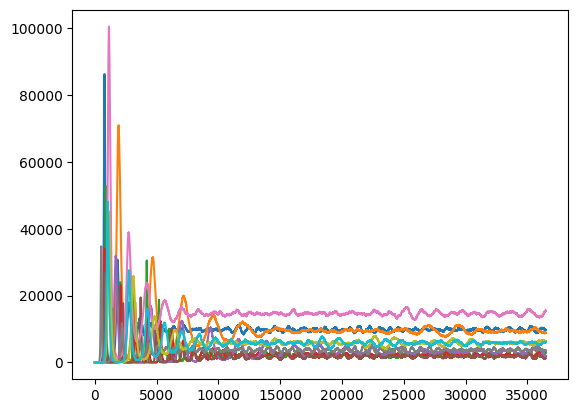

In [12]:
# import os

nsims = 10
nticks = 36500
cbrs = 30 + 50 * np.random.rand(nsims)
inf_means = 5 + 45 * np.random.rand(nsims)
R0s = 2.5 + 7.5 * np.random.rand(nsims)
mu = [((1 + cbr / 1000) ** (1 / 365) - 1) for cbr in cbrs]
A = [1 / ((R0 - 1) * mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1 / (mu + 1 / inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
T_exp = [2 * math.pi * np.sqrt(A * G) for A, G in zip(A, G)]
mycases = np.zeros((nsims, nticks))
params_df = pd.DataFrame(
    {
        "cbr": cbrs,
        "inf_mean": inf_means,
        "R0": R0s,
        "A": A,
        "G": G,
        "T_exp": T_exp,
    }
)
i = 0
for cbr, inf_mean, R0 in zip(cbrs, inf_means, R0s):
    mu = (1 + cbr / 1000) ** (1 / 365) - 1
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 36500,
            "verbose": True,
            "beta": R0 * (mu + 1 / inf_mean),
            "inf_mean": inf_mean,
            "cbr": cbr,
            "importation_period": 180,
            "importation_count": 3,
        }
    )
    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]

    set_initial_susceptibility_randomly(model, 1 / R0 + 0.02)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    plt.plot(model.patches.cases)
    mycases[i] = np.squeeze(model.patches.cases)
    i = i + 1

# output_folder = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "laser-generic-outputs", "periodicity"))
# os.makedirs(output_folder, exist_ok=True)
# params_df.to_csv(os.path.join(output_folder, "params_df.csv"), index=False)
# np.save(os.path.join(output_folder, "mycases.npy"), mycases)

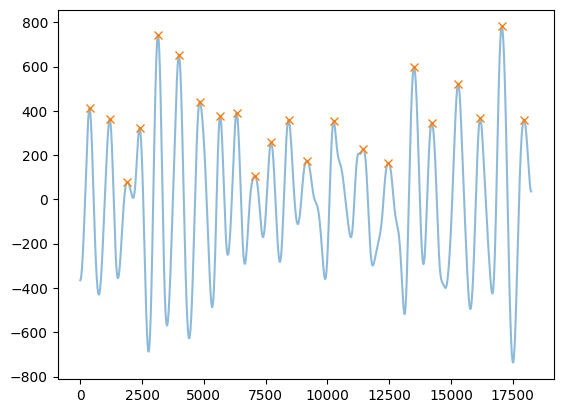

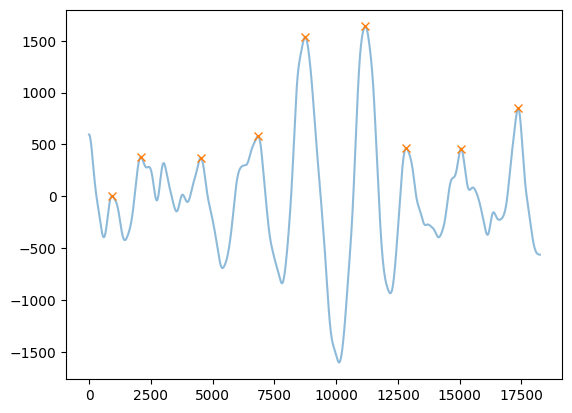

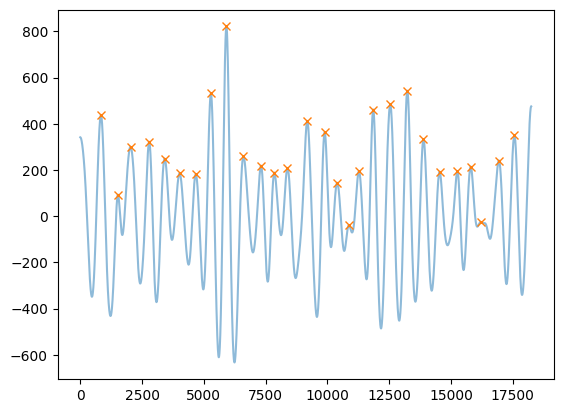

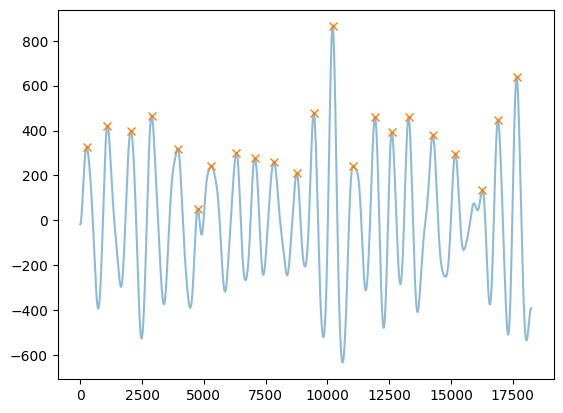

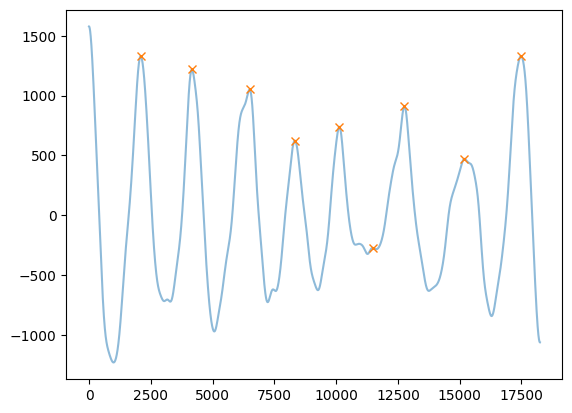

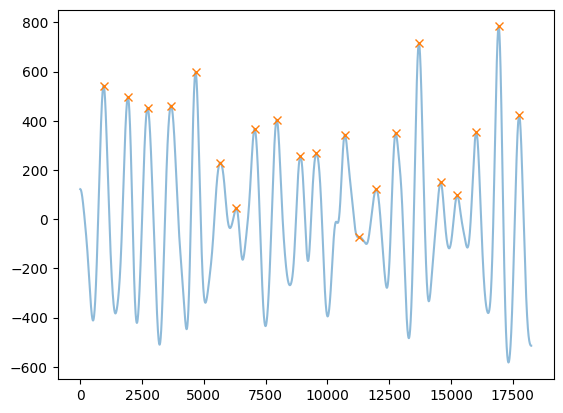

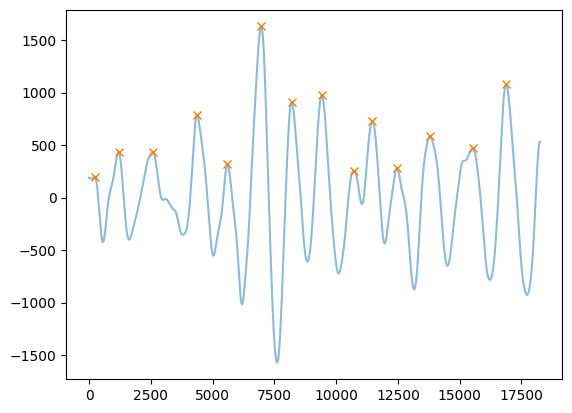

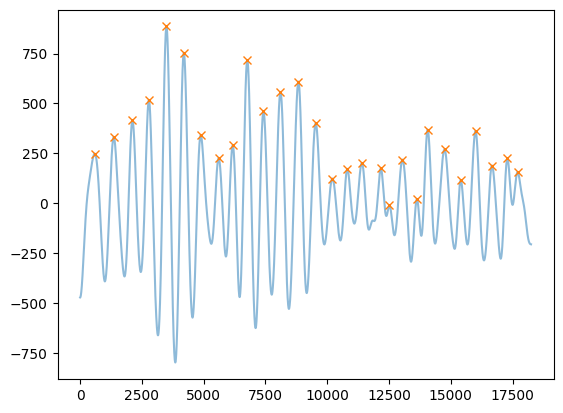

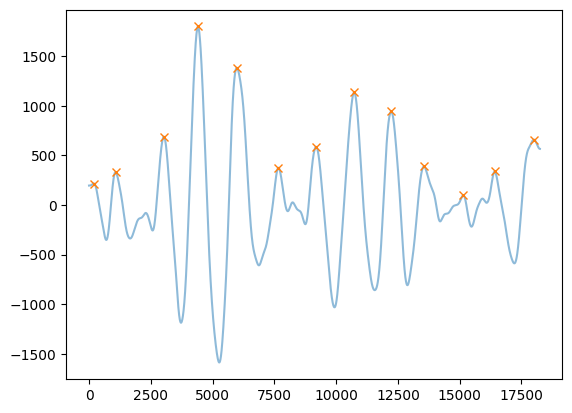

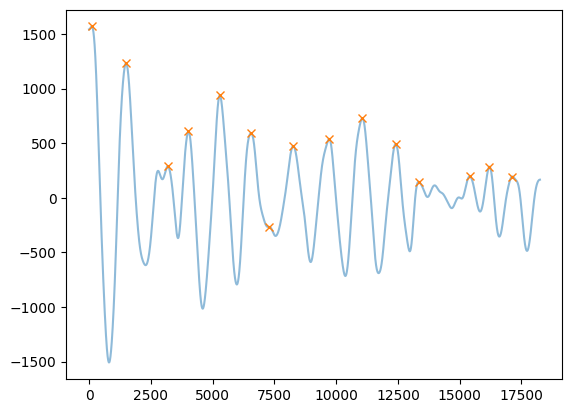

In [15]:
params_df["T_obs_peakfinder"] = np.nan
params_df["T_obs_autocorr"] = np.nan

for i in range(mycases.shape[0]):
    params_df.loc[i, "T_obs_peakfinder"] = ID_freq_peakfinder(np.squeeze(mycases[i, :]), params_df.loc[i, "T_exp"], plot=False)
    params_df.loc[i, "T_obs_autocorr"] = ID_freq_autocorr(np.squeeze(mycases[i, :]))

In [17]:
params_df

,cbr,inf_mean,R0,A,G,T_exp,T_obs_peakfinder,T_obs_autocorr
0,74.934966,28.841175,8.362558,1.879444,0.078568,2.414450,2.254795,2.230137
1,63.781161,43.599935,2.894722,8.535337,0.118576,6.321042,6.205479,6.093151
2,79.583556,7.388431,4.932963,3.320057,0.020211,1.627593,1.717808,1.769863
3,53.160648,10.087311,6.023295,3.843139,0.027597,2.046226,2.284932,2.172603
4,35.480394,24.917049,3.352254,12.192688,0.068104,5.725524,5.343836,5.926027
5,36.079926,11.273769,7.308830,4.471815,0.030853,2.333847,2.341096,2.410959
6,67.323580,49.493410,6.506610,2.786985,0.134411,3.845601,3.553425,3.569863
7,58.937385,13.921366,8.701065,2.267351,0.038058,1.845695,1.821918,1.868493
8,40.840474,32.883485,5.817138,5.185820,0.089768,4.286959,4.198630,4.243836
9,57.379795,24.964564,4.712656,4.827196,0.068136,3.603427,3.468493,3.663014


In [1]:
plt.plot(params_df["T_exp"], params_df["T_obs_peakfinder"], "o")

NameError: name 'plt' is not defined

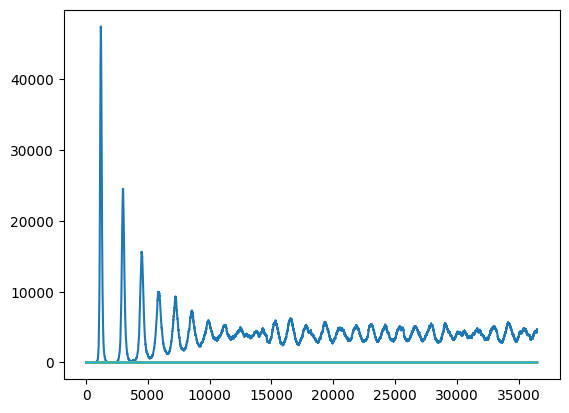